
![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

# Cargando datos de imagenes reales
Hasta ahora sólo hemos trabajado con conjuntos de datos de juguete (MNIST, CIFAR-10) convenientemente empaquetados por torchvision, donde cada imagen tiene el mismo tamaño y forma. Ahora vamos a trabajar con una colección variada de archivos .jpg.

En esta sección trabajaremos con una versión del conjunto de datos Gatos contra Perros inspirada en una clásica competición <a href='https://www.kaggle.com/c/dogs-vs-cats'>Kaggle</a>.<br>
Nota rápida: <strong>no</strong> descargar el dataset de Kaggle! El nuestro es una versión preprocesada de los datos sin ficheros 0by0, etc.<br>Las imágenes son similares a las disponibles en la base de datos <a href='http://www.image-net.org/'>ImageNet</a>.

Hemos organizado los archivos en carpetas de entrenamiento y prueba, y dividido además las imágenes en subcarpetas CAT y DOG. De este modo, la ruta del archivo contiene la etiqueta.

### Arbol de directorio de imágenes
<pre>../
└── IA3_data
    └── CATS_DOGS
        ├── test
        │   ├── CAT
        │   │   ├── 9374.jpg
        │   │   ├── 9375.jpg
        │   │   └── ... (3,126 files)
        │   └── DOG
        │       ├── 9374.jpg
        │       ├── 9375.jpg
        │       └── ... (3,125 files)       
        │           
        └── train
            ├── CAT
            │   ├── 0.jpg
            │   ├── 1.jpg
            │   └── ... (9,371 files)
            └── DOG
                ├── 0.jpg
                ├── 1.jpg
                └── ... (9,372 files)</pre>

## Importaciones

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Emplearemos el <a href='https://docs.python.org/3/library/os.html'>modulo os</a> para recorrer los directorios cogiendo los nombres de los ficheros.

A continuación usaremos <a href='https://python-pillow.org/'>Pillow</a>, una extensión de la Python Imaging Library (PIL), para abrir archivos de imagen y extraer tamaños de imagen. Un DataFrame de pandas proporcionará estadísticas resumidas sobre nuestros datos, como la anchura y la altura máximas y mínimas, a partir de las cuales podemos elegir los parámetros de nuestro modelo.

In [ ]:
import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

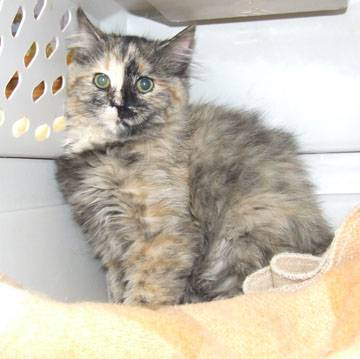

In [ ]:
with Image.open('/content/drive/MyDrive/Colab Notebooks/IA3/IA3_data/CATS_DOGS/test/CAT/cat.4005.jpg') as im:
#with Image.open('../Data/CATS_DOGS/test/CAT/10107.jpg') as im:
    display(im)

### Creación de una lista de nombres de imagenes

Para procesar las imágenes puede ser útil crear una lista con la ruta completa de las imágenes como nombre. De esta forma se puede emplear para mezclarlas, seleccionar subconjuntos, etc.

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/IA3/IA3_data/CATS_DOGS'
#path = '..\\Data\\CATS_DOGS\\'
img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        #img_names.append(folder+'\\'+img)
        img_names.append(folder+'/'+img)

print('Images: ',len(img_names))

Images:  10003


In [ ]:
img_names[0:10]

['/content/drive/MyDrive/Colab Notebooks/Datos/CNNs/CATS_DOGS/single_prediction/cat.4003.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Datos/CNNs/CATS_DOGS/single_prediction/cat_or_dog_1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Datos/CNNs/CATS_DOGS/single_prediction/cat_or_dog_2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Datos/CNNs/CATS_DOGS/test/CAT/cat.4029.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Datos/CNNs/CATS_DOGS/test/CAT/cat.4003.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Datos/CNNs/CATS_DOGS/test/CAT/cat.4048.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Datos/CNNs/CATS_DOGS/test/CAT/cat.4025.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Datos/CNNs/CATS_DOGS/test/CAT/cat.4016.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Datos/CNNs/CATS_DOGS/test/CAT/cat.4026.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Datos/CNNs/CATS_DOGS/test/CAT/cat.4022.jpg']

### Creación un DataFrame de tamaños de imagen (ancho x alto)
Frente a un dataset no conocido, es importante hacer algun tipo de exploración preliminar, para hacernos una idea de las imágenes que tenemos y decidir adecuadamente el procesado en los siguientes pasos.

Vale la pena señalar que <tt>Image.open()</tt> no lee toda la imagen en la memoria, por lo que es una forma razonable de obtener tamaños de imagen.<br>
Aún así, esta operación puede requerir **bastante tiempo**.

In [ ]:
# Start by creating a list
img_sizes = []
rejected = []

for item in img_names[1:5000]: # All images takes a lot of time
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)

print(f'Images:  {len(img_sizes)}')
print(f'Rejects: {len(rejected)}')

Images:  4999
Rejects: 0


In [ ]:
# Convert the list to a DataFrame
df = pd.DataFrame(img_sizes)

# Run summary statistics on image widths
df[0].describe()

count    4999.000000
mean      408.637728
std       112.843836
min        59.000000
25%       330.000000
50%       459.000000
75%       499.000000
max      2560.000000
Name: 0, dtype: float64

In [ ]:
# Run summary statistics on image heights
df[1].describe()

count    4999.000000
mean      357.691938
std        99.039830
min        33.000000
25%       299.000000
50%       374.000000
75%       415.000000
max      1600.000000
Name: 1, dtype: float64

A la vista de esta exploración, vemos la anchura más baja, la altura más corta, la anchura y la altura más grandes, etc. Un detalle importante es que la mayoría de las imágenes tienen más de 300 píxeles por lado. Esto es útil para decidir un tamaño de entrada. Veremos en la siguiente sección que 224x224 funcionará bien para nuestros propósitos (¡aprovecharemos algunos modelos preentrenados que utilizan este tamaño!).

## Preprocesamiento de imágenes
Cualquier red que definamos requiere datos de entrada consistentes. Es decir, los archivos de imagen de entrada deben tener el mismo número de canales (3 para rojo/verde/azul), la misma profundidad por canal (0-255), y la misma altura y anchura. Este último requisito puede ser complicado. ¿Cómo transformamos una imagen de 800x450 píxeles en una de 224x224? Hemos de tener claro los siguientes conceptos:
* <a href='https://en.wikipedia.org/wiki/Aspect_ratio_(image)'><strong>aspect ratio</strong></a>: la relación entre la anchura y la altura (16:9, 1:1, etc.) Una imagen de 800x450 píxeles tiene una relación de aspecto de 16:9. Podemos cambiar la relación de aspecto de una imagen recortándola, estirándola o comprimiéndola, o mediante una combinación de ambas. En ambos casos se pierde parte de la información contenida en el original. Supongamos que recortamos 175 píxeles de los lados izquierdo y derecho de nuestra imagen de 800x450, obteniendo una de 450x450.
* <strong>scala</strong>: Una vez que hemos conseguido la relación de aspecto adecuada, puede que necesitemos aumentar o reducir la escala de una imagen para ajustarla a nuestros parámetros de entrada. Hay varias librerías que podemos utilizar para reducir una imagen de 450x450 a 224x224 con una pérdida mínima.
* <a href=''><strong>normalizacion</strong></a>: cuando las imágenes son convertidas a tensores, el rango [0,255] de los canales rgb son transformados al rango [0,1]. A continuación, podemos normalizarlos utilizando los valores generalmente aceptados de media=[0,485, 0,456, 0,406] y std=[0,229, 0,224, 0,225]. (Para los curiosos, estos valores fueron obtenidos por el equipo de PyTorch utilizando una muestra aleatoria de 10.000 muestras de las imágenes de <a href='http://www.image-net.org/'>ImageNet</a>.
Hay una buena discusión sobre esto <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>aquí</a>, y el código fuente original se puede encontrar <a href='https://github.com/soumith/imagenet-multiGPU.torch/blob/master/donkey.lua#L154'>aquí</a>.)

## Transformaciones
Antes de definir nuestra red convolucional, veamos una imagen de muestra y realicemos varias transformaciones sobre ella para ver su efecto.

(500, 386)


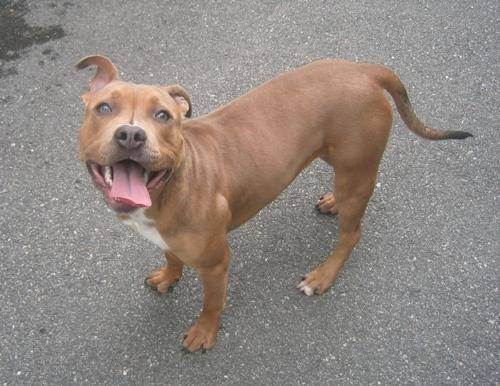

In [ ]:
dog = Image.open('/content/drive/MyDrive/Colab Notebooks/Datos/CNNs/CATS_DOGS/train/DOG/dog.14.jpg')
print(dog.size)
display(dog)

Así es como jupyter muestra la imagen .jpg original. Ten en cuenta que el tamaño se da como (ancho, alto).<br>
Vamos a ver un píxel individual:

In [ ]:
r, g, b = dog.getpixel((0, 0))
print(r,g,b)

89 97 100


El píxel en la posición [0,0] (arriba a la izquierda) de la imagen de origen tiene un valor rgb de (90,95,98). Esto corresponde a <font style="background-color:rgb(90,95,98);">este color </font><br>

Veamos algunas transformaciones habituales.
### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor'><tt>transforms.ToTensor()</tt></a>
Convierte una imagen PIL o numpy.ndarray (HxWxC) en el rango [0, 255] a un <tt>torch.FloatTensor</tt> de dimensiones (CxHxW) en el rango [0.0, 1.0]

torch.Size([3, 386, 500])


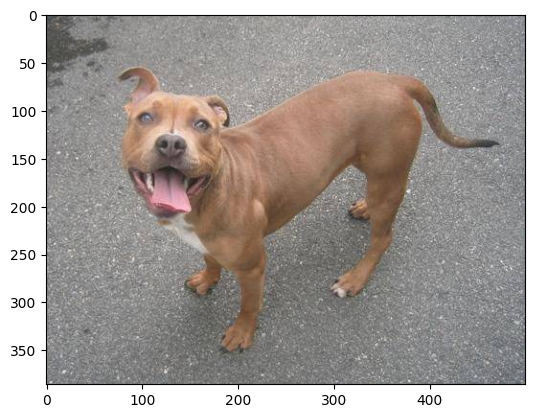

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Esta es la misma imagen convertida a tensor y visualizada usando matplotlib. Nótese que las dimensiones torch siguen siendo [channel, height, width]<br><br>
PyTorch carga automáticamente los valores de píxeles [0,255] en [0,1]:<br><br>
$\frac{89}{255}=0.3490\quad\frac{97}{255}=0.3804\quad\frac{100}{255}=0.3922$

In [ ]:
im[:,0,0]

tensor([0.3490, 0.3804, 0.3922])

### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Resize'><tt>transforms.Resize(<em>size</em>)</tt></a>
Si el tamaño es una secuencia como (h, w), el tamaño de salida coincidirá con éste. Si el tamaño es un número entero, el borde más pequeño de la imagen se ajustará a este número.<br>i.e, si altura > anchura, entonces la imagen se reescala a (size * height / width, size)

torch.Size([3, 224, 290])


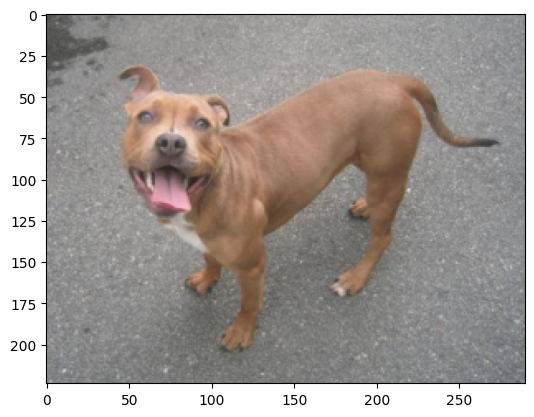

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Esto redimensiona el lado más corto, y escala el otro. Vamos a probar esto en una imagen pequeña:

(135, 101)


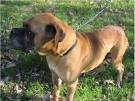

In [ ]:
small_dog = Image.open('/content/drive/MyDrive/Colab Notebooks/Datos/CNNs/CATS_DOGS/train/DOG/dog.11.jpg')
print(small_dog.size)
display(small_dog)

torch.Size([3, 224, 299])


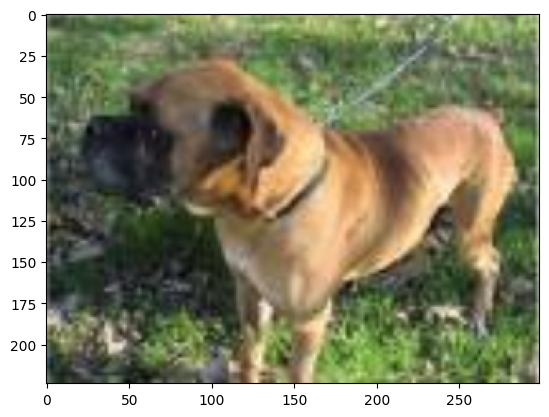

In [ ]:
im = transform(small_dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.CenterCrop'><tt>transforms.CenterCrop(<em>size</em>)</tt></a>
Si el tamaño es un número entero en lugar de una secuencia como (h, w), se realiza un recorte cuadrado de (tamaño, tamaño).

torch.Size([3, 224, 224])


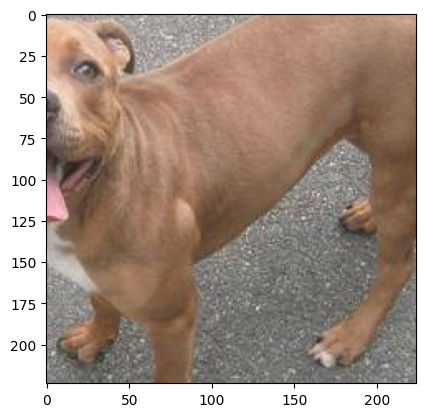

In [ ]:
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
im = transform(dog) # this crops the original image
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Es mejor cambiar primero el tamaño de la imagen y luego recortarla:

torch.Size([3, 224, 224])


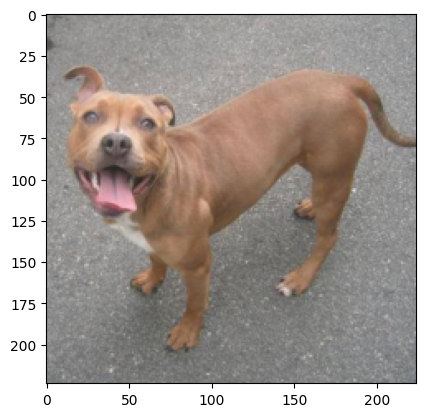

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Otras transformaciones afines
Una <a href='https://en.wikipedia.org/wiki/Affine_transformation'><em>affine</em></a> transformation es aquella que conserva los puntos y las líneas rectas. Algunos ejemplos son la rotación, la reflexión y el escalado. Por ejemplo, podemos duplicar el tamaño efectivo de nuestro conjunto de entrenamiento simplemente volteando las imágenes.
### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomHorizontalFlip'><tt>transforms.RandomHorizontalFlip(<em>p=0.5</em>)</tt></a>
Voltea horizontalmente la imagen PIL dada aleatoriamente con una probabilidad dada.

torch.Size([3, 386, 500])


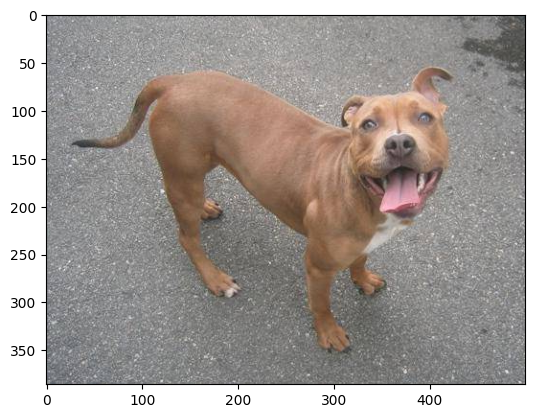

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # normally we'd set p=0.5
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomRotation'><tt>transforms.RandomRotation(<em>degrees</em>)</tt></a>
Si grados es un número en lugar de una secuencia como (min, max), el rango de grados será (-grados, +grados).<br>
Ejecute la celda de abajo varias veces para ver una muestra de rotaciones.

torch.Size([3, 386, 500])


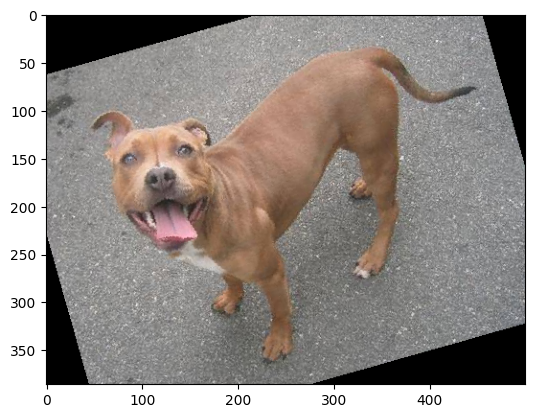

In [ ]:
transform = transforms.Compose([
    transforms.RandomRotation(30),  # rotate randomly between +/- 30 degrees
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### Escalado se realiza con <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Resize'><tt>transforms.Resize(<em>size</em>)</tt></a>

Si pasamos una tupla (HxW) **obligamos** a reescalar la imagen a esas dimensiones. Esto puede causar deformaciones, ya que no se preserva el**aspect_ratio**

torch.Size([3, 224, 224])


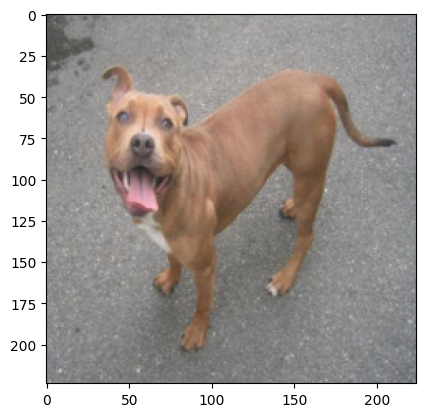

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),  # be sure to pass in a list or a tuple
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Todo junto

Lo interesante es definir todas las transformaciones de forma que se ejecuten secuencialmente para cada imagen.

torch.Size([3, 224, 224])


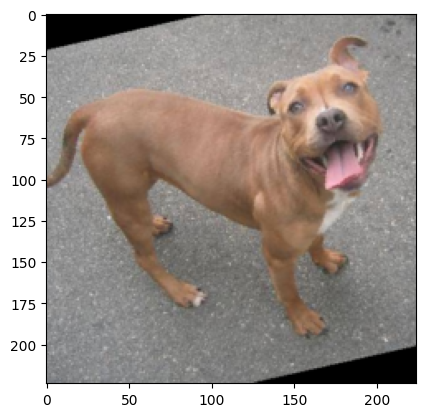

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # normally we'd set p=0.5
    transforms.RandomRotation(30),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

___
## Normalización
Una vez que la imagen ha sido cargada en un tensor, podemos realizar una normalización sobre ella. Esto sirve para que la convergencia sea más rápida durante el entrenamiento. Los valores son algo arbitrarios - se puede utilizar una media de 0,5 y una desviación estándar de 0,5 para convertir un rango de [0,1] a [-1,1], por ejemplo.<br>Sin embargo, <a href='https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22'>hay trabajos de investigación</a> que apuntan a que media=[0.485, 0.456, 0.406] y std=[0.229, 0.224, 0.225] funcionan bien en la práctica.

### <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt>transforms.Normalize(<em>mean, std</em>)</tt></a>
Dada la media: (M1,...,Mn) y la std: (S1,..,Sn) para n canales, esta transformación normalizará cada canal del tensor de entrada
### $\quad\textrm {input[channel]} = \frac{\textrm{input[channel] - mean[channel]}}{\textrm {std[channel]}}$

torch.Size([3, 386, 500])


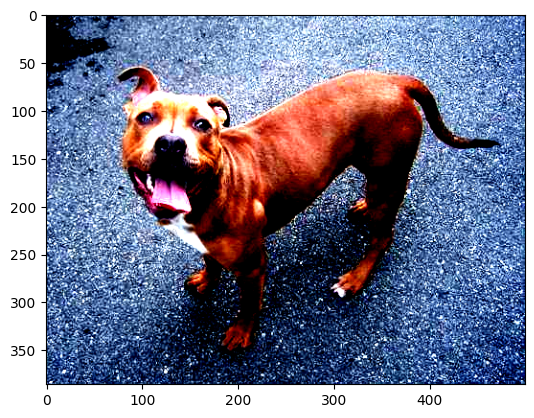

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Recall that before normalization, the upper-leftmost tensor had pixel values of <tt>[0.3529, 0.3725, 0.3843]</tt>.<br>
With normalization we subtract the channel mean from the input channel, then divide by the channel std.<br><br>
$\frac{(0.3490-0.485)}{0.229}=-0.5938\quad\frac{(0.3804-0.456)}{0.224}=-0.3375\quad\frac{(0.3922-0.406)}{0.225}=-0.0615$<br>

In [ ]:
# After normalization:
im[:,0,0]

tensor([-0.5938, -0.3375, -0.0615])

En la imagen de muestra, matplotlib recorta este píxel en particular hasta [0,0,0], por lo que aparece negro en la pantalla. Sin embargo, la apariencia no es importante; el objetivo de la normalización es **mejorar el rendimiento matemático**.

### Des-normalizar las imágenes
Para volver a ver la imagen en sus colores reales, podemos aplicar una transformación inversa al tensor visualizado.

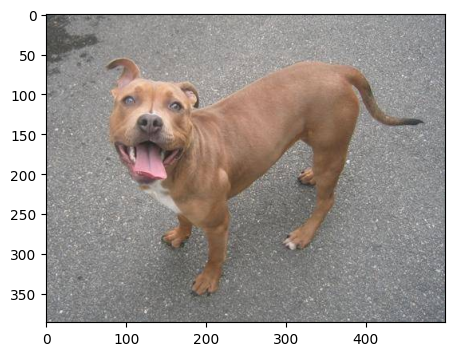

In [ ]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

Observa que el tensor original no ha sido modificado:

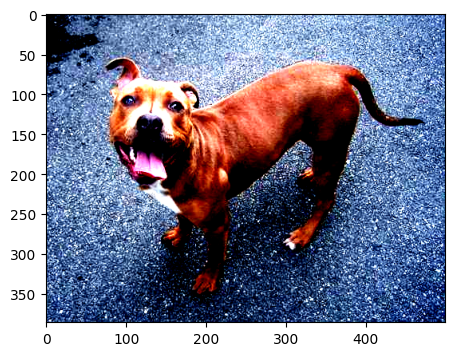

In [ ]:
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Siguiente: emplear CNNs en imágenes reales!